In [4]:
%matplotlib inline

import os
import datacube
import warnings
import pydotplus
import numpy as np
import geopandas as gpd
from io import StringIO
from joblib import dump
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
from odc.io.cgroups import get_cpu_quota
from sklearn import tree, model_selection
from sklearn.metrics import accuracy_score
from datacube.utils.cog import write_cog

#from Sachen.deafrica.Tools.deafrica_tools.plotting import map_shapefile, rgb
#from Sachen.deafrica.Tools.deafrica_tools.classification import predict_xr, collect_training_data
#from Sachen.deafrica.Tools.deafrica_tools.bandindices import calculate_indices

from deafrica_tools.plotting import map_shapefile, rgb
from deafrica_tools.classification import predict_xr, collect_training_data
from deafrica_tools.bandindices import calculate_indices

warnings.filterwarnings('ignore')
dc = datacube.Datacube(app='Machine_learning_with_ODC')

In [6]:
path = '../data/wahgnion_mine.geojson'
field = 'class'
products = 's2_l2a'
measurements =  ['blue','green','red']
time = ('2020-01-03')
zonal_stats = None #'median' 
resolution =  (-10, 10)


ul = (-5.42677,10.40975)
lr = (-5.35220, 10.33943)
lon = (-5.42677, -5.35220)
lat = (10.33943, 10.40975)

[Wahgnion Mine](https://www.endeavourmining.com/our-business/our-assets/wahgnion-mine)

In [8]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path)#.to_crs('epsg:4326')

map_data = gpd.read_file(path).to_crs('epsg:4326')
#check the shapfile by plotting it
map_shapefile(map_data, attribute=field)

Label(value='')

Map(center=[10.379243407128074, -5.388903046338598], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [9]:
input_data

,id,class,geometry
0,0,0,POINT (-5.36555 10.39330)
1,0,0,POINT (-5.36555 10.39330)
2,0,0,POINT (-5.36555 10.39330)
3,0,0,POINT (-5.36555 10.39330)
4,0,0,POINT (-5.36555 10.39330)
...,...,...,...
208,1,1,POINT (-5.41658 10.39309)
209,1,1,POINT (-5.41726 10.39304)
210,1,1,POINT (-5.41771 10.39330)
211,1,1,POINT (-5.41641 10.39380)


In [11]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
dem_cop_30,dem_cop_30,Copernicus DEM 30 m,None,EPSG:4326,"(-0.0002777777777777778, 0.0002777777777777778)"
esa_worldcover,esa_worldcover,"ESA World Cover, global 10 m land use/land cov...",None,EPSG:4326,"(-8.333333333333333e-05, 8.333333333333333e-05)"
io_lulc,io_lulc,Impact Observatory (ESRI) Landcover Classifica...,None,None,None
ls7_sr,ls7_sr,USGS Landsat 7 Collection 2 Level-2 Surface Re...,CC-BY-4.0,None,None
ls7_st,ls7_st,USGS Landsat 7 Collection 2 Level-2 Surface Te...,CC-BY-4.0,None,None
ls8_sr,ls8_sr,USGS Landsat 8 Collection 2 Level-2 Surface Re...,CC-BY-4.0,None,None
ls8_st,ls8_st,USGS Landsat 8 Collection 2 Level-2 Surface Te...,CC-BY-4.0,None,None
rainfall_chirps_daily,rainfall_chirps_daily,Rainfall Estimates from Rain Gauge and Satelli...,None,EPSG:4326,"(-0.05000000074505806, 0.05000000074505806)"
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,EPSG:4326,"(-0.0002, 0.0002)"


In [10]:
# query for feature_func()
# generate a datacube query object
# ONLY for checking 
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs' : 'epsg:6933',
    'group_by' : 'solar_day'
}

In [11]:
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load ls8 geomedian
    ds = dc.load(product=products,
                 **query)
    #ds = ds.median()

    
    return ds

In [12]:
# generate a datacube query object
# ONLY for checking 
check = {
    'time': time,
    'x' : lon,
    'y' : lat,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs' : 'epsg:6933',
    'group_by' : 'solar_day'
}

In [13]:
dataset = dc.load(products,
                  **check, 
                  dask_chunks={"time": 1, "x": 100, "y": 100})

In [14]:
dataset

<xarray.Dataset>
Dimensions:      (time: 1, y: 884, x: 720)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T10:58:15
  * y            (y) float64 1.321e+06 1.321e+06 ... 1.312e+06 1.312e+06
  * x            (x) float64 -5.236e+05 -5.236e+05 ... -5.164e+05 -5.164e+05
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [15]:
dataset=dc.load(product=products,
       x=lon, 
       y=lat,
       time=time,
       measurements=measurements,
       resolution=resolution,
       output_crs='epsg:6933',
       group_by = 'solar_day',
       dask_chunks={"time": 1, "x": 100, "y": 100})

In [16]:
dataset

<xarray.Dataset>
Dimensions:      (time: 1, y: 884, x: 720)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T10:58:15
  * y            (y) float64 1.321e+06 1.321e+06 ... 1.312e+06 1.312e+06
  * x            (x) float64 -5.236e+05 -5.236e+05 ... -5.164e+05 -5.164e+05
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

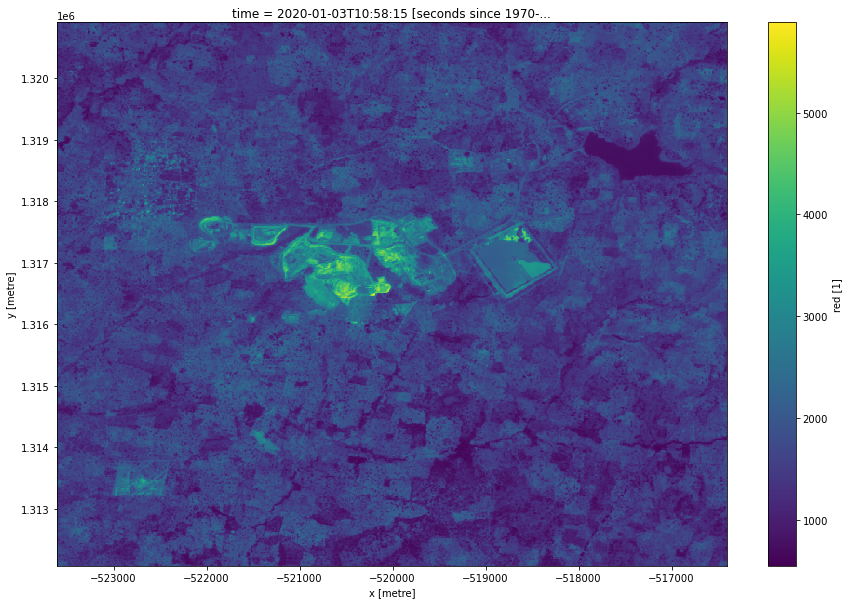

In [20]:
dataset.red.isel(time=0).plot.imshow(size=10)

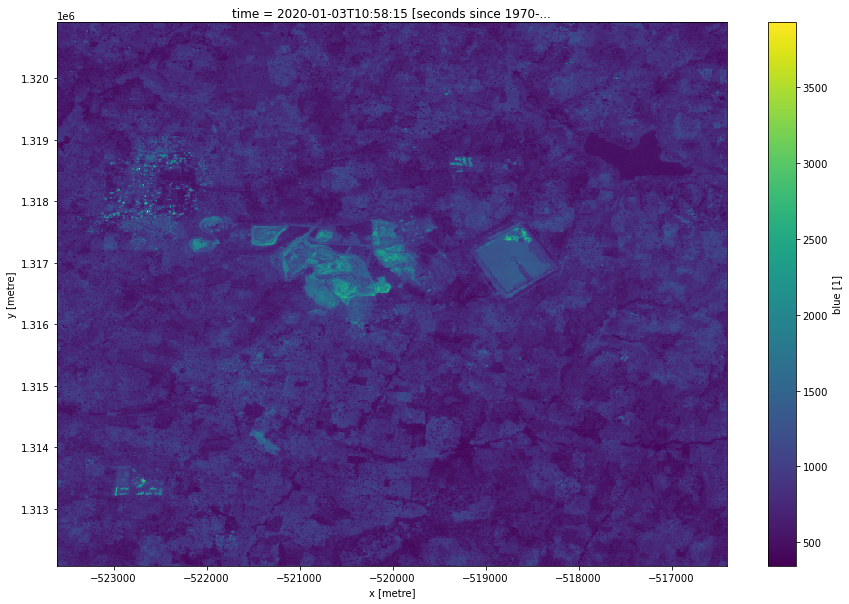

In [21]:
dataset.blue.isel(time=0).plot.imshow(size=10)

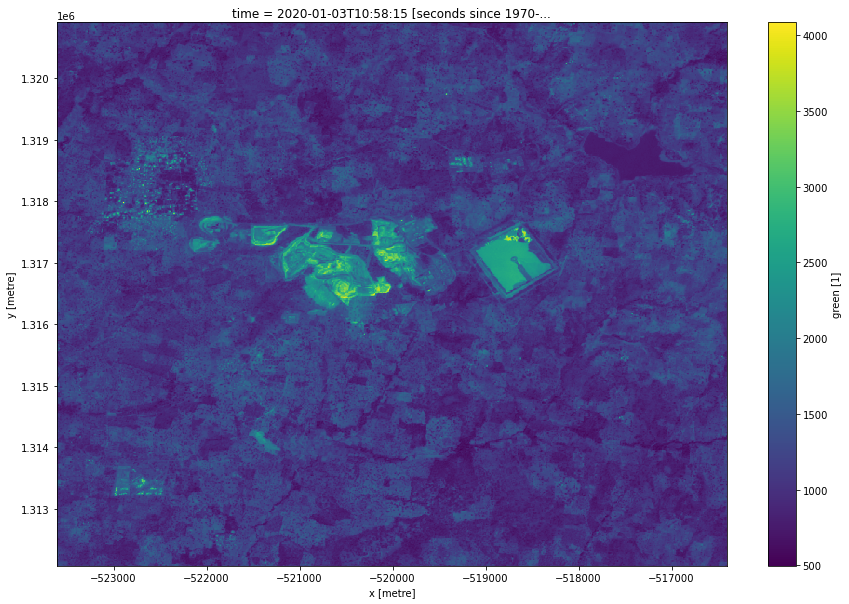

In [22]:
dataset.green.isel(time=0).plot.imshow(size=10)

In [23]:
input_data = input_data.to_crs('epsg:6933')

In [24]:
#Collect the training data from the datacube
column_names, model_input = collect_training_data(
                                    gdf=input_data,
                                    dc_query=query,
                                    ncpus=1,
                                    field=field,
                                    zonal_stats=zonal_stats,
                                    feature_func=feature_layers
                                    )

Removed 0 rows wth NaNs &/or Infs
Output shape:  (213, 4)


In [25]:
column_names

['class', 'blue', 'green', 'red']

In [30]:
print(column_names)
print('')
print(np.array_str(model_input, suppress_small=True))

['class', 'blue', 'green', 'red']

[[   0.  514.  777.  778.]
 [   0.  514.  777.  778.]
 [   0.  514.  777.  778.]
 [   0.  514.  777.  778.]
 [   0.  514.  777.  778.]
 [   0.  528.  788.  834.]
 [   0.  516.  769.  821.]
 [   0.  523.  766.  766.]
 [   0.  485.  740.  734.]
 [   0.  491.  778.  733.]
 [   0.  496.  768.  725.]
 [   0.  536.  793.  757.]
 [   0.  536.  793.  757.]
 [   0.  525.  753.  777.]
 [   0.  501.  758.  738.]
 [   0.  508.  747.  755.]
 [   0.  498.  745.  724.]
 [   0.  501.  763.  752.]
 [   0.  505.  773.  736.]
 [   0.  505.  773.  736.]
 [   0.  505.  773.  736.]
 [   0.  504.  756.  781.]
 [   0.  620.  860. 1003.]
 [   0.  529.  761.  766.]
 [   0.  529.  761.  766.]
 [   0.  517.  777.  761.]
 [   0.  509.  777.  766.]
 [   0.  534.  748.  742.]
 [   0.  534.  788.  773.]
 [   0.  521.  774.  778.]
 [   0.  490.  773.  760.]
 [   0.  482.  773.  764.]
 [   0.  529.  777.  794.]
 [   0.  514.  799.  780.]
 [   0.  535.  765.  780.]
 [   0.  527.  768. 

In [43]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (170, 4)
Test shape: (43, 4)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [44]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below by adding or changing variables in the `classifier_params` below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [45]:
classifier_params = {'criterion': 'gini',
                     'max_depth' : 10,
                     'splitter' : 'random',
                     'min_samples_split' : 100}

model = tree.DecisionTreeClassifier(**classifier_params, random_state=1)

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [46]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(max_depth=10, min_samples_split=100, random_state=1,
                       splitter='random')

### Optionally save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in other scripts should we wish to use the same model to classify a different region.

To import a saved model, execute the following code snippet:

    from joblib import load
    ml_model = 'ml_model.joblib'
    model = load(ml_model)

In [15]:
dump(model, 'ml_model.joblib')

['ml_model.joblib']

---

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Determining our overall accuracy,
* Finding out which features (bands in the input data) are most useful for classifying, and which are not,
* Plotting the Decision Tree to help us understand which thresholds are used to seperate the classes.

### Overall Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [47]:
predictions = model.predict(model_test[:, model_col_indices])

str(round(accuracy_score(predictions, model_test[:, 0]), 2) *100) +  ' %'

#str(round(accuracy_score(predictions, model_test[:, 0], 2) *100)) + ' %'

#str(round(accuracy_score(predictions, model_test[:, 0], 2) *100)) + ' %'

#round(accuracy_score(predictions, model_test[:, 0]), 4)

#accuracy_score(predictions, model_test[:, 0])

'93.0 %'

### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

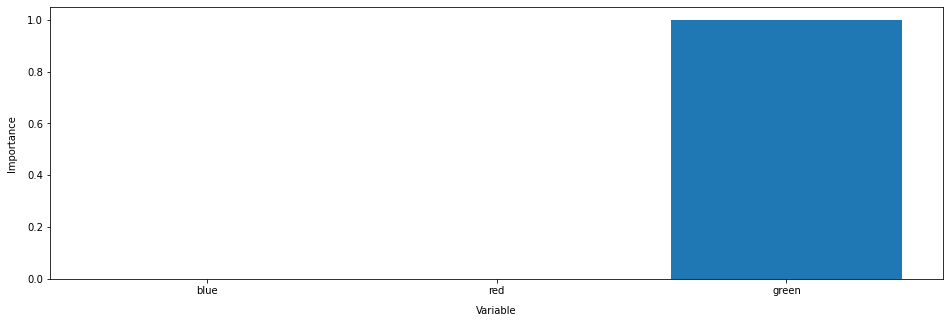

In [48]:
# This shows the feature importance of the input features for predicting the class labels provided
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(16,5))
plt.bar(x=np.array(model_variables)[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

### Plot the Decision Tree

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** (or **entropy**) value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

> This step can take a long time if using `feature_stats = None`

If the graph is small double-click to enlarge it. Double-click again to return to initial size.

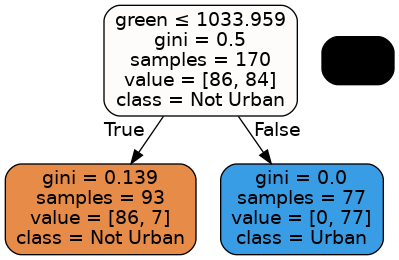

In [49]:
# Prepare a dictionary of class names
class_names = {1: 'Urban',
               0: 'Not Urban'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph = Image(graph.create_png())
graph

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.

> If you changed any of the parameters in the `Analysis Parameters` section from their default values, then these changes will need to be reflected in the code below. For the prediction section to work, it requires loading the same data as is loaded in the training data. The user needs to update this section manually.


In [51]:
# Load the data based on query around the user supplied
# lat/long and buffer 
q = {'x': (lon),
     'y': (lat)}

query.update(q)

#calculate features
data = feature_layers(query)
data = data.where(data!=0, np.nan)

print(data)

<xarray.Dataset>
Dimensions:      (time: 1, y: 884, x: 720)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T10:58:15
  * y            (y) float64 1.321e+06 1.321e+06 ... 1.312e+06 1.312e+06
  * x            (x) float64 -5.236e+05 -5.236e+05 ... -5.164e+05 -5.164e+05
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float64 754.0 899.0 782.0 ... 842.0 735.0 585.0
    green        (time, y, x) float64 1.118e+03 1.302e+03 ... 1.011e+03 847.0
    red          (time, y, x) float64 1.442e+03 1.688e+03 ... 1.096e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [52]:
# Predict landcover using the trained model
predicted = predict_xr(model, data, clean=True)

predicting...


## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - Use the `Evaluate Classifier` steps below to help you improve the model

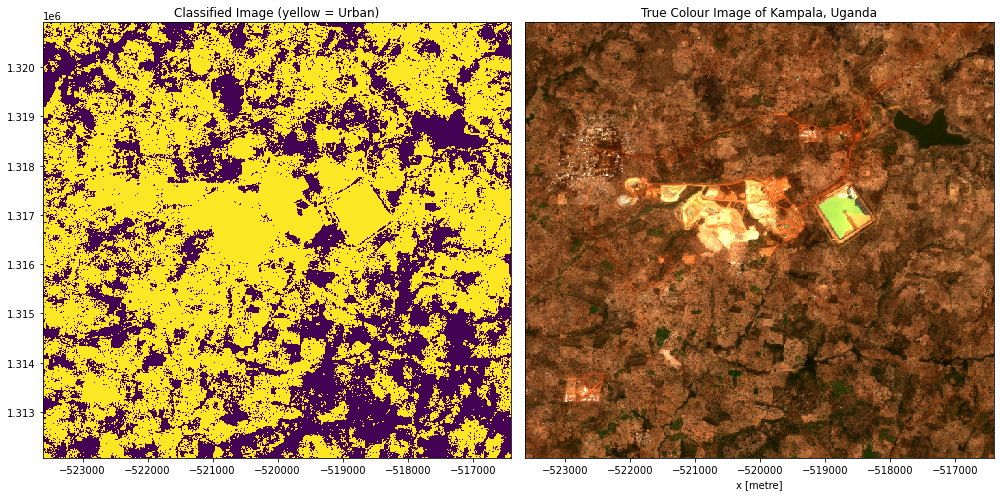

In [53]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='viridis', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(data, ax=axes[1], percentile_stretch=(0.01, 0.99))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified Image (yellow = Urban)')
axes[1].set_title('True Colour Image of Kampala, Uganda')
plt.tight_layout();

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [22]:
write_cog(predicted.Predictions,
          fname="predicted.tif",
          overwrite=True)

PosixPath('predicted.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.4


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-08-17'